In [93]:
from IPython.display import HTML
import random
def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'
    toggle_text = 'Toggle show/hide'  
    target_cell = this_cell  
    js_hide_current = ''
    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'
    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))
    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}
            {js_hide_current}
        </script>
        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )
    return HTML(html)

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi

In [2]:
train = pd.read_csv('Train.csv')

In [3]:
test = pd.read_csv('Test.csv')

In [4]:
submission = pd.read_csv('sample_submission.csv')

# EDA (Exploratory Data Analysis)

In [5]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [6]:
train.shape

(8068, 11)

In [7]:
test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [8]:
test.shape

(2627, 10)

In [9]:
submission.head()

,ID,Segmentation
0,458989,A
1,458994,A
2,458996,A
3,459000,A
4,459001,A


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


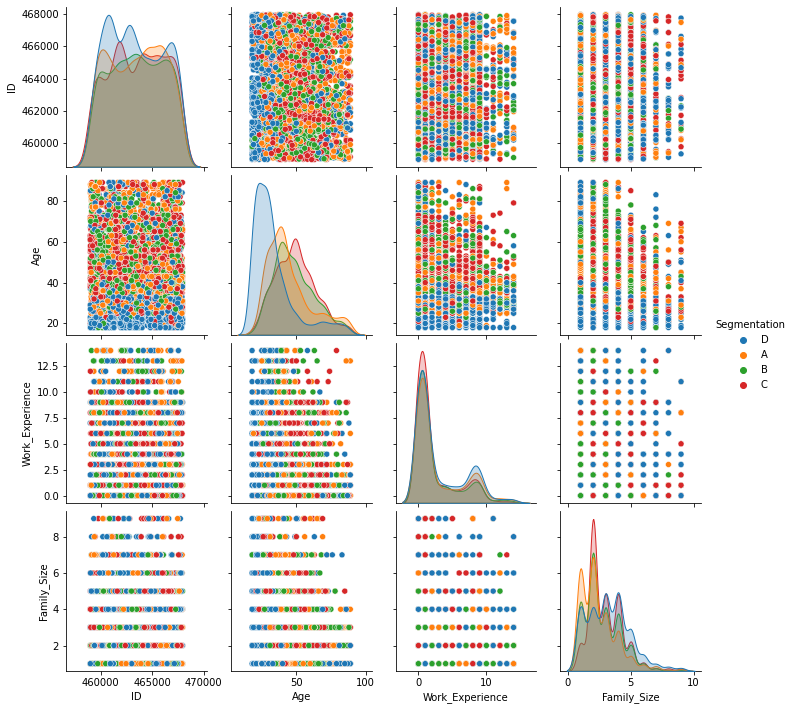

In [11]:
sns.pairplot(train, hue='Segmentation')

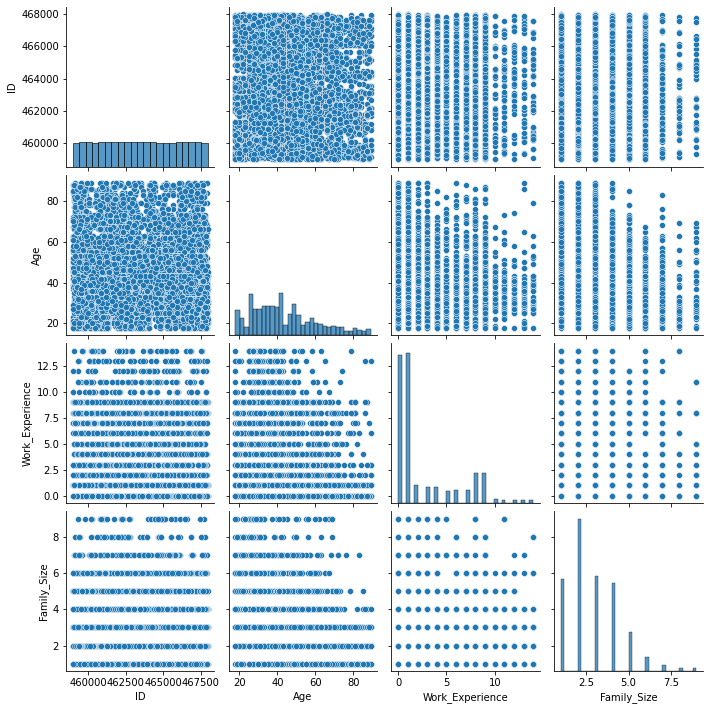

In [12]:
sns.pairplot(train)

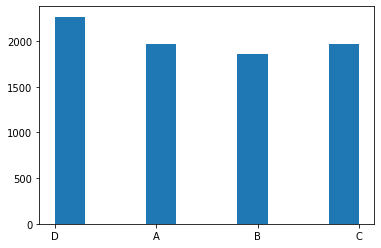

In [13]:
plt.hist(train.Segmentation);

<AxesSubplot:>

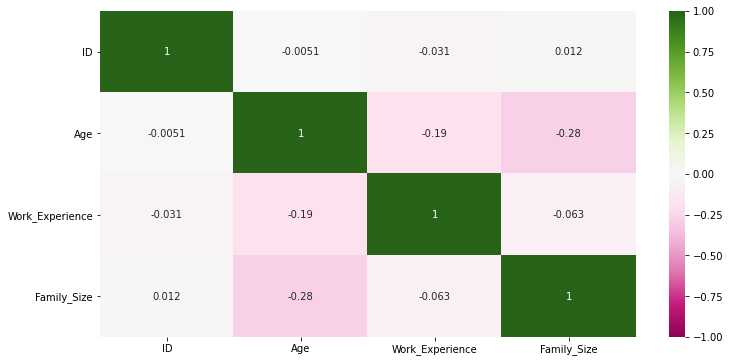

In [14]:
fig = plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), cmap='PiYG', vmin=-1, annot=True)

<AxesSubplot:ylabel='Segmentation'>

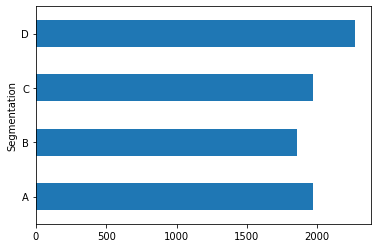

In [15]:
train.groupby('Segmentation')['ID'].agg('count').plot(kind='barh')

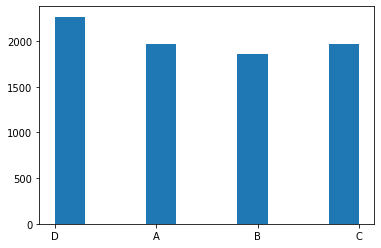

In [16]:
plt.hist(train.Segmentation);

In [17]:
train.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [18]:
train.Gender.value_counts(normalize=True)

Male      0.547471
Female    0.452529
Name: Gender, dtype: float64

In [19]:
train.Profession.value_counts(normalize=True)

Artist           0.316717
Healthcare       0.167674
Entertainment    0.119461
Engineer         0.087991
Doctor           0.086606
Lawyer           0.078424
Executive        0.075403
Marketing        0.036757
Homemaker        0.030967
Name: Profession, dtype: float64

In [20]:
train.Graduated.value_counts(normalize=True)

Yes    0.621777
No     0.378223
Name: Graduated, dtype: float64

In [21]:
train.Family_Size.value_counts(normalize=True)

2.0    0.309065
3.0    0.193586
1.0    0.187896
4.0    0.178327
5.0    0.079141
6.0    0.027415
7.0    0.012414
8.0    0.006466
9.0    0.005690
Name: Family_Size, dtype: float64

In [22]:
train.pivot_table(index=train.Segmentation, aggfunc='count')

,Age,Ever_Married,Family_Size,Gender,Graduated,ID,Profession,Spending_Score,Var_1,Work_Experience
Segmentation,,,,,,,,,,
A,1972,1938,1877,1972,1948,1972,1939,1972,1953,1778
B,1858,1827,1815,1858,1840,1858,1836,1858,1845,1666
C,1970,1947,1926,1970,1955,1970,1952,1970,1949,1815
D,2268,2216,2115,2268,2247,2268,2217,2268,2245,1980


In [23]:
train['Spending_Score'].agg(pd.Series.mode)

,0
0,Low
1,Average
2,Low
3,High
4,High
...,...
8063,Low
8064,Low
8065,Low
8066,Low


In [24]:
segmentation = train.pivot_table(index=train.Segmentation, aggfunc={'Work_Experience' : 'mean',
                                                                    'Age': 'mean',
                                                                    'Family_Size':'mean'})

In [25]:
spending = train.groupby(train.Segmentation)['Spending_Score'].agg(pd.Series.mode)

In [26]:
married = train.groupby(train.Segmentation)['Ever_Married'].agg(pd.Series.mode)

In [27]:
graduated = train.groupby(train.Segmentation)['Graduated'].agg(pd.Series.mode)

In [28]:
profession =  train.groupby(train.Segmentation)['Profession'].agg(pd.Series.mode)


In [29]:
gender = train.groupby(train.Segmentation)['Gender'].agg(pd.Series.mode)

In [30]:
count = train.groupby(train.Segmentation)['ID'].agg('count')

In [31]:
var = train.groupby(train.Segmentation)['Var_1'].agg(pd.Series.mode)

In [32]:
segmentation = pd.concat([segmentation, spending], axis=1)

In [33]:
segmentation = pd.concat([segmentation, married], axis=1)

In [34]:
segmentation = pd.concat([segmentation, graduated], axis=1)

In [35]:
segmentation = pd.concat([segmentation, profession], axis=1)

In [36]:
segmentation = pd.concat([segmentation, var], axis=1)

In [37]:
segmentation = pd.concat([segmentation, count], axis=1)

In [38]:
segmentation = pd.concat([segmentation, gender], axis=1)

In [39]:
segmentation

,Age,Family_Size,Work_Experience,Spending_Score,Ever_Married,Graduated,Profession,Var_1,ID,Gender
Segmentation,,,,,,,,,,
A,44.924949,2.439531,2.874578,Low,Yes,Yes,Artist,Cat_6,1972,Male
B,48.200215,2.696970,2.378151,Low,Yes,Yes,Artist,Cat_6,1858,Male
C,49.144162,2.974559,2.240771,Average,Yes,Yes,Artist,Cat_6,1970,Male
D,33.390212,3.232624,3.021717,Low,No,No,Healthcare,Cat_6,2268,Male


In [40]:
train.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [41]:
train.groupby(train.Segmentation).Graduated.value_counts()

Segmentation  Graduated
A             Yes          1219
              No            729
B             Yes          1332
              No            508
C             Yes          1607
              No            348
D             No           1437
              Yes           810
Name: Graduated, dtype: int64

<AxesSubplot:ylabel='Segmentation,Gender'>

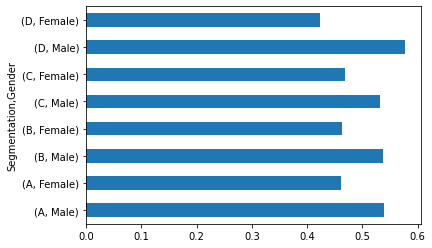

In [42]:
train.groupby(train.Segmentation).Gender.value_counts(normalize=True).plot(kind='barh')

<AxesSubplot:ylabel='Segmentation,Spending_Score'>

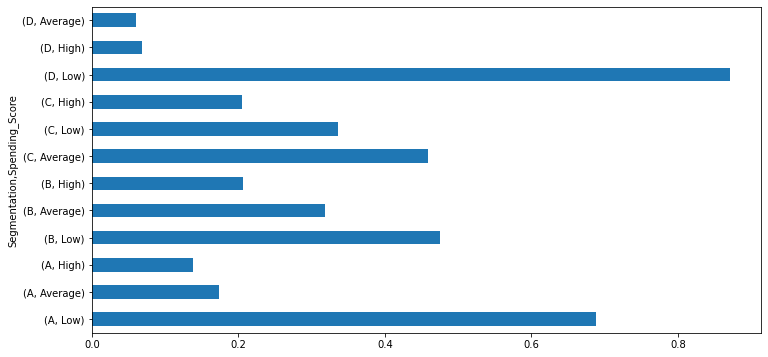

In [43]:
fig = plt.figure(figsize=(12,6))
train.groupby(train.Segmentation).Spending_Score.value_counts(normalize=True).plot(kind='barh')

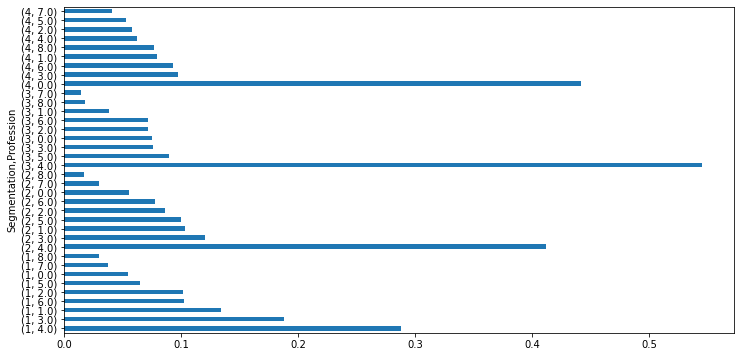

In [94]:
fig = plt.figure(figsize=(12,6))
train.groupby(train.Segmentation).Profession.value_counts(normalize=True).plot(kind='barh')
hide_toggle()

<AxesSubplot:ylabel='Segmentation,Family_Size'>

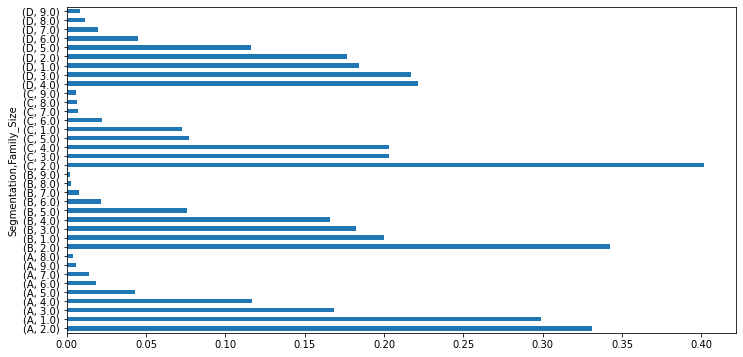

In [45]:
fig = plt.figure(figsize=(12,6))
train.groupby(train.Segmentation).Family_Size.value_counts(normalize=True).plot(kind='barh')

In [46]:
train.ID.count()

8068

In [47]:
train

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


C:\Users\israe\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ID', ylabel='Age'>

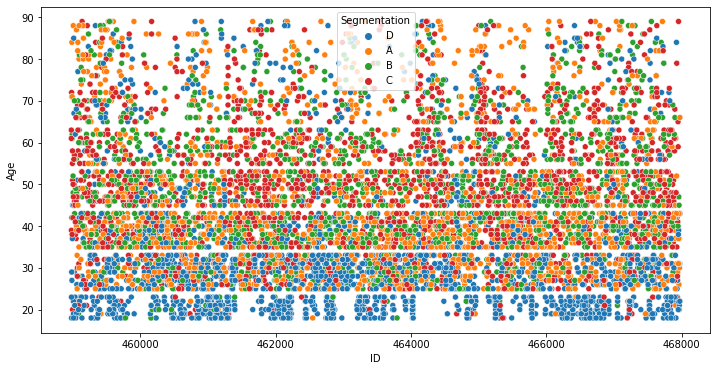

In [48]:
fig = plt.figure(figsize=(12,6))
sns.scatterplot(train.ID, train.Age,  hue=train.Segmentation)

C:\Users\israe\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ID', ylabel='Profession'>

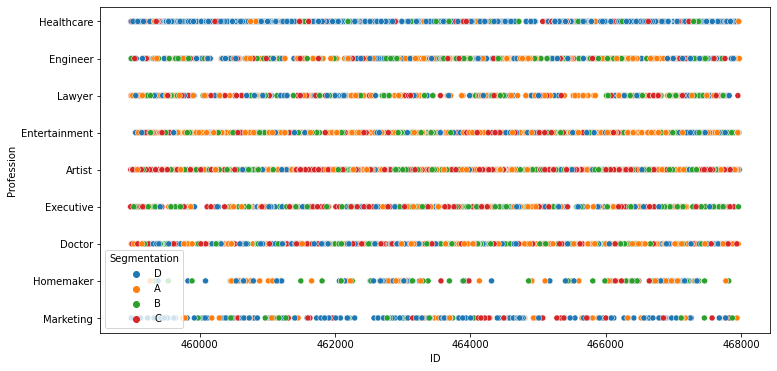

In [49]:
fig = plt.figure(figsize=(12,6))
sns.scatterplot(train.ID, train.Profession, hue=train.Segmentation)

C:\Users\israe\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ID', ylabel='Spending_Score'>

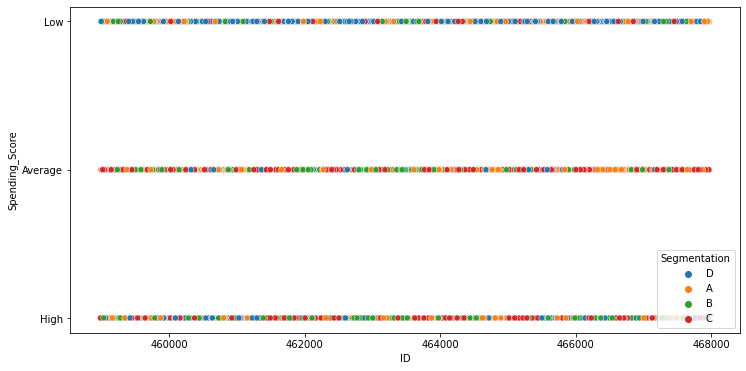

In [50]:
fig = plt.figure(figsize=(12,6))
sns.scatterplot(train.ID, train.Spending_Score, hue=train.Segmentation)

<AxesSubplot:ylabel='Segmentation,Gender'>

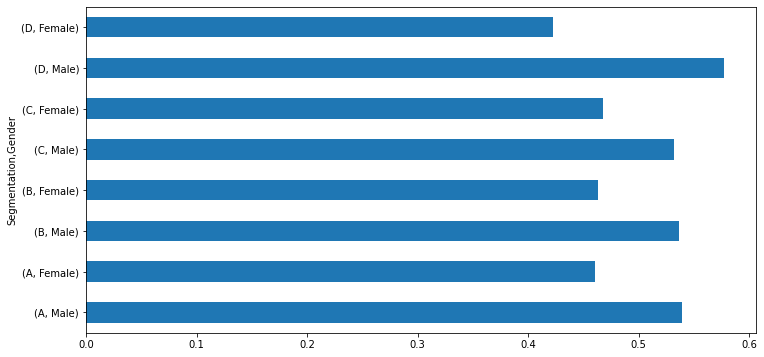

In [51]:
fig = plt.figure(figsize=(12,6))
train.groupby(train.Segmentation).Gender.value_counts(normalize=True).plot(kind='barh')

In [52]:
train.loc[train['Segmentation']=='A'].groupby(train.Segmentation).agg('count')

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
Segmentation,,,,,,,,,,,
A,1972,1972,1938,1972,1948,1939,1778,1972,1877,1953,1972


In [53]:
segmentation.rename(columns={'ID' : 'Count'}, inplace=True)

In [54]:
segmentation

,Age,Family_Size,Work_Experience,Spending_Score,Ever_Married,Graduated,Profession,Var_1,Count,Gender
Segmentation,,,,,,,,,,
A,44.924949,2.439531,2.874578,Low,Yes,Yes,Artist,Cat_6,1972,Male
B,48.200215,2.696970,2.378151,Low,Yes,Yes,Artist,Cat_6,1858,Male
C,49.144162,2.974559,2.240771,Average,Yes,Yes,Artist,Cat_6,1970,Male
D,33.390212,3.232624,3.021717,Low,No,No,Healthcare,Cat_6,2268,Male


In [55]:
train['Var_1'] = train['Var_1'].str.replace('Cat_', '')

In [56]:
train.isna().sum().sort_values(ascending=False)

Work_Experience    829
Family_Size        335
Ever_Married       140
Profession         124
Graduated           78
Var_1               76
ID                   0
Gender               0
Age                  0
Spending_Score       0
Segmentation         0
dtype: int64

In [57]:
train['Var_1'].isna()==False

0       True
1       True
2       True
3       True
4       True
        ... 
8063    True
8064    True
8065    True
8066    True
8067    True
Name: Var_1, Length: 8068, dtype: bool

In [58]:
train['Var_1'].notna()


0       True
1       True
2       True
3       True
4       True
        ... 
8063    True
8064    True
8065    True
8066    True
8067    True
Name: Var_1, Length: 8068, dtype: bool

In [59]:
train['Var_1'] = train.loc[train['Var_1'].isna()==False]['Var_1'].apply(lambda x : int(x))

In [60]:
train['Var_1'].isna().sum()

76

<AxesSubplot:>

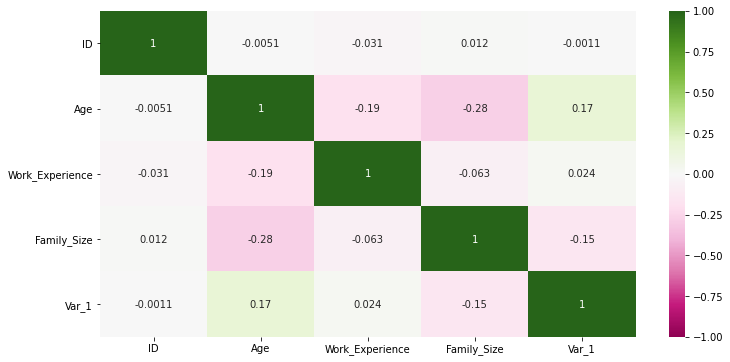

In [61]:
fig = plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), cmap='PiYG', vmin=-1, annot=True)

In [62]:
train.Segmentation.unique()

array(['D', 'A', 'B', 'C'], dtype=object)

In [63]:
dct = {'A':1, 'B':2 , 'C':3, 'D':4}

In [64]:
train['Segmentation'] = train['Segmentation'].map(dct)

<AxesSubplot:>

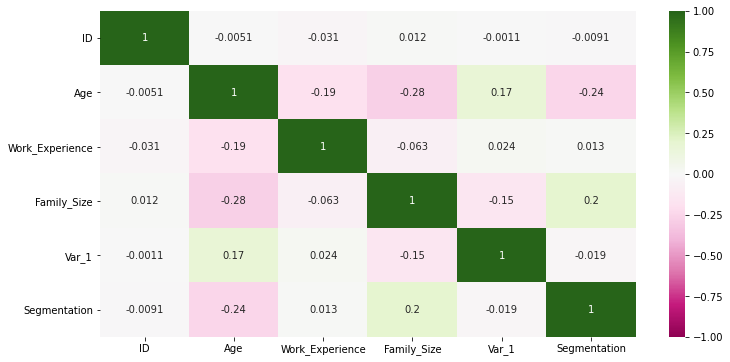

In [65]:
fig = plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), cmap='PiYG', vmin=-1, annot=True)

In [66]:
train.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [67]:
train['Gender'] = train['Gender'].map({'Male':0, 'Female':1})

In [68]:
train['Gender']

0       0
1       1
2       1
3       0
4       1
       ..
8063    0
8064    0
8065    1
8066    1
8067    0
Name: Gender, Length: 8068, dtype: int64

<AxesSubplot:>

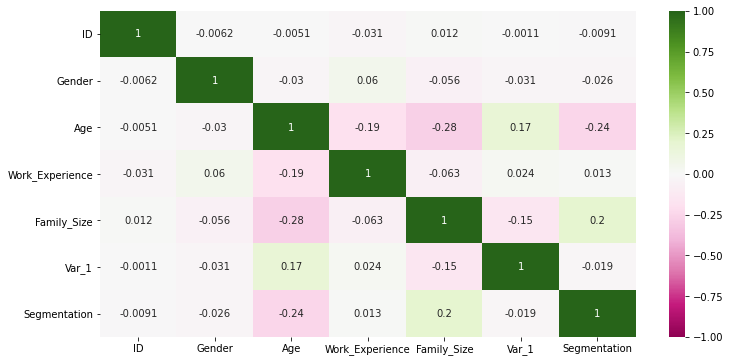

In [69]:
fig = plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), cmap='PiYG', vmin=-1, annot=True)

In [70]:
train

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,0,No,22,No,Healthcare,1.0,Low,4.0,4.0,4
1,462643,1,Yes,38,Yes,Engineer,NaN,Average,3.0,4.0,1
2,466315,1,Yes,67,Yes,Engineer,1.0,Low,1.0,6.0,2
3,461735,0,Yes,67,Yes,Lawyer,0.0,High,2.0,6.0,2
4,462669,1,Yes,40,Yes,Entertainment,NaN,High,6.0,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,0,No,22,No,NaN,0.0,Low,7.0,1.0,4
8064,464685,0,No,35,No,Executive,3.0,Low,4.0,4.0,4
8065,465406,1,No,33,Yes,Healthcare,1.0,Low,1.0,6.0,4
8066,467299,1,No,27,Yes,Healthcare,1.0,Low,4.0,6.0,2


In [71]:
train.Ever_Married.unique()

array(['No', 'Yes', nan], dtype=object)

In [72]:
train.isna().sum().sort_values(ascending=False)

Work_Experience    829
Family_Size        335
Ever_Married       140
Profession         124
Graduated           78
Var_1               76
ID                   0
Gender               0
Age                  0
Spending_Score       0
Segmentation         0
dtype: int64

In [73]:
train['Ever_Married'] = train['Ever_Married'].map({'No':0, 'Yes':1})

In [74]:
train.isna().sum().sort_values(ascending=False)

Work_Experience    829
Family_Size        335
Ever_Married       140
Profession         124
Graduated           78
Var_1               76
ID                   0
Gender               0
Age                  0
Spending_Score       0
Segmentation         0
dtype: int64

In [75]:
train.Graduated.unique()

array(['No', 'Yes', nan], dtype=object)

In [76]:
train['Graduated'] = train['Graduated'].map({'No':0, 'Yes':1})

In [77]:
train.isna().sum().sort_values(ascending=False)

Work_Experience    829
Family_Size        335
Ever_Married       140
Profession         124
Graduated           78
Var_1               76
ID                   0
Gender               0
Age                  0
Spending_Score       0
Segmentation         0
dtype: int64

In [78]:
train

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,0,0.0,22,0.0,Healthcare,1.0,Low,4.0,4.0,4
1,462643,1,1.0,38,1.0,Engineer,NaN,Average,3.0,4.0,1
2,466315,1,1.0,67,1.0,Engineer,1.0,Low,1.0,6.0,2
3,461735,0,1.0,67,1.0,Lawyer,0.0,High,2.0,6.0,2
4,462669,1,1.0,40,1.0,Entertainment,NaN,High,6.0,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,0,0.0,22,0.0,NaN,0.0,Low,7.0,1.0,4
8064,464685,0,0.0,35,0.0,Executive,3.0,Low,4.0,4.0,4
8065,465406,1,0.0,33,1.0,Healthcare,1.0,Low,1.0,6.0,4
8066,467299,1,0.0,27,1.0,Healthcare,1.0,Low,4.0,6.0,2


<AxesSubplot:>

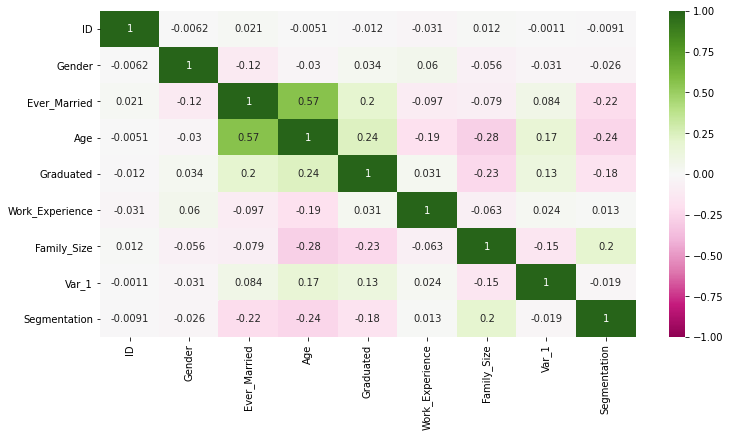

In [79]:
fig = plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), cmap='PiYG', vmin=-1, annot=True)

In [80]:
train.Spending_Score.unique()

array(['Low', 'Average', 'High'], dtype=object)

In [81]:
train['Spending_Score'] = train['Spending_Score'].map({'Low':1, 'Average':2, 'High':3 })

In [82]:
train.isna().sum().sort_values(ascending=False)

Work_Experience    829
Family_Size        335
Ever_Married       140
Profession         124
Graduated           78
Var_1               76
ID                   0
Gender               0
Age                  0
Spending_Score       0
Segmentation         0
dtype: int64

<AxesSubplot:>

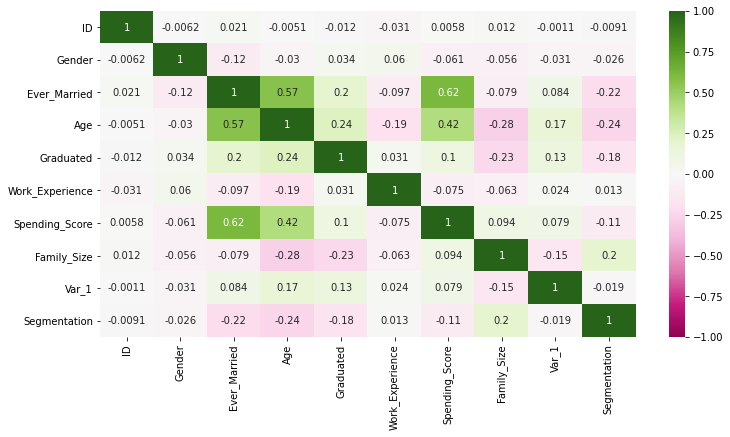

In [83]:
fig = plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), cmap='PiYG', vmin=-1, annot=True)

In [84]:
train.Profession.unique()

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing', nan], dtype=object)

In [85]:
train.isna().sum().sort_values(ascending=False)

Work_Experience    829
Family_Size        335
Ever_Married       140
Profession         124
Graduated           78
Var_1               76
ID                   0
Gender               0
Age                  0
Spending_Score       0
Segmentation         0
dtype: int64

In [86]:
dct2 = {'Healthcare' : 0, 'Engineer':1, 'Lawyer':2, 'Entertainment':3, 'Artist':4,
       'Executive':5, 'Doctor':6, 'Homemaker':7, 'Marketing':8}

In [87]:
train['Profession'] = train['Profession'].map(dct2)

In [88]:
train.isna().sum().sort_values(ascending=False)

Work_Experience    829
Family_Size        335
Ever_Married       140
Profession         124
Graduated           78
Var_1               76
ID                   0
Gender               0
Age                  0
Spending_Score       0
Segmentation         0
dtype: int64

<AxesSubplot:>

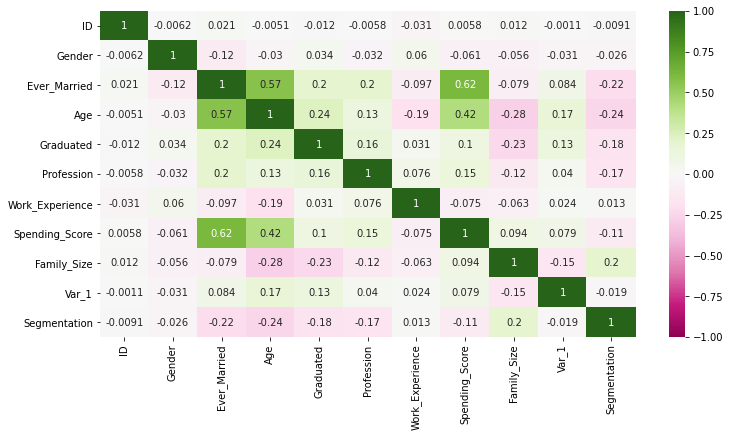

In [89]:
fig = plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), cmap='PiYG', vmin=-1, annot=True)

In [90]:
train

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,0,0.0,22,0.0,0.0,1.0,1,4.0,4.0,4
1,462643,1,1.0,38,1.0,1.0,NaN,2,3.0,4.0,1
2,466315,1,1.0,67,1.0,1.0,1.0,1,1.0,6.0,2
3,461735,0,1.0,67,1.0,2.0,0.0,3,2.0,6.0,2
4,462669,1,1.0,40,1.0,3.0,NaN,3,6.0,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,0,0.0,22,0.0,NaN,0.0,1,7.0,1.0,4
8064,464685,0,0.0,35,0.0,5.0,3.0,1,4.0,4.0,4
8065,465406,1,0.0,33,1.0,0.0,1.0,1,1.0,6.0,4
8066,467299,1,0.0,27,1.0,0.0,1.0,1,4.0,6.0,2


In [91]:
train.corrwith(train['Segmentation']).abs().sort_values(ascending=False)

Segmentation       1.000000
Age                0.243552
Ever_Married       0.218508
Family_Size        0.196213
Graduated          0.179233
Profession         0.165366
Spending_Score     0.109837
Gender             0.026403
Var_1              0.018812
Work_Experience    0.012993
ID                 0.009104
dtype: float64

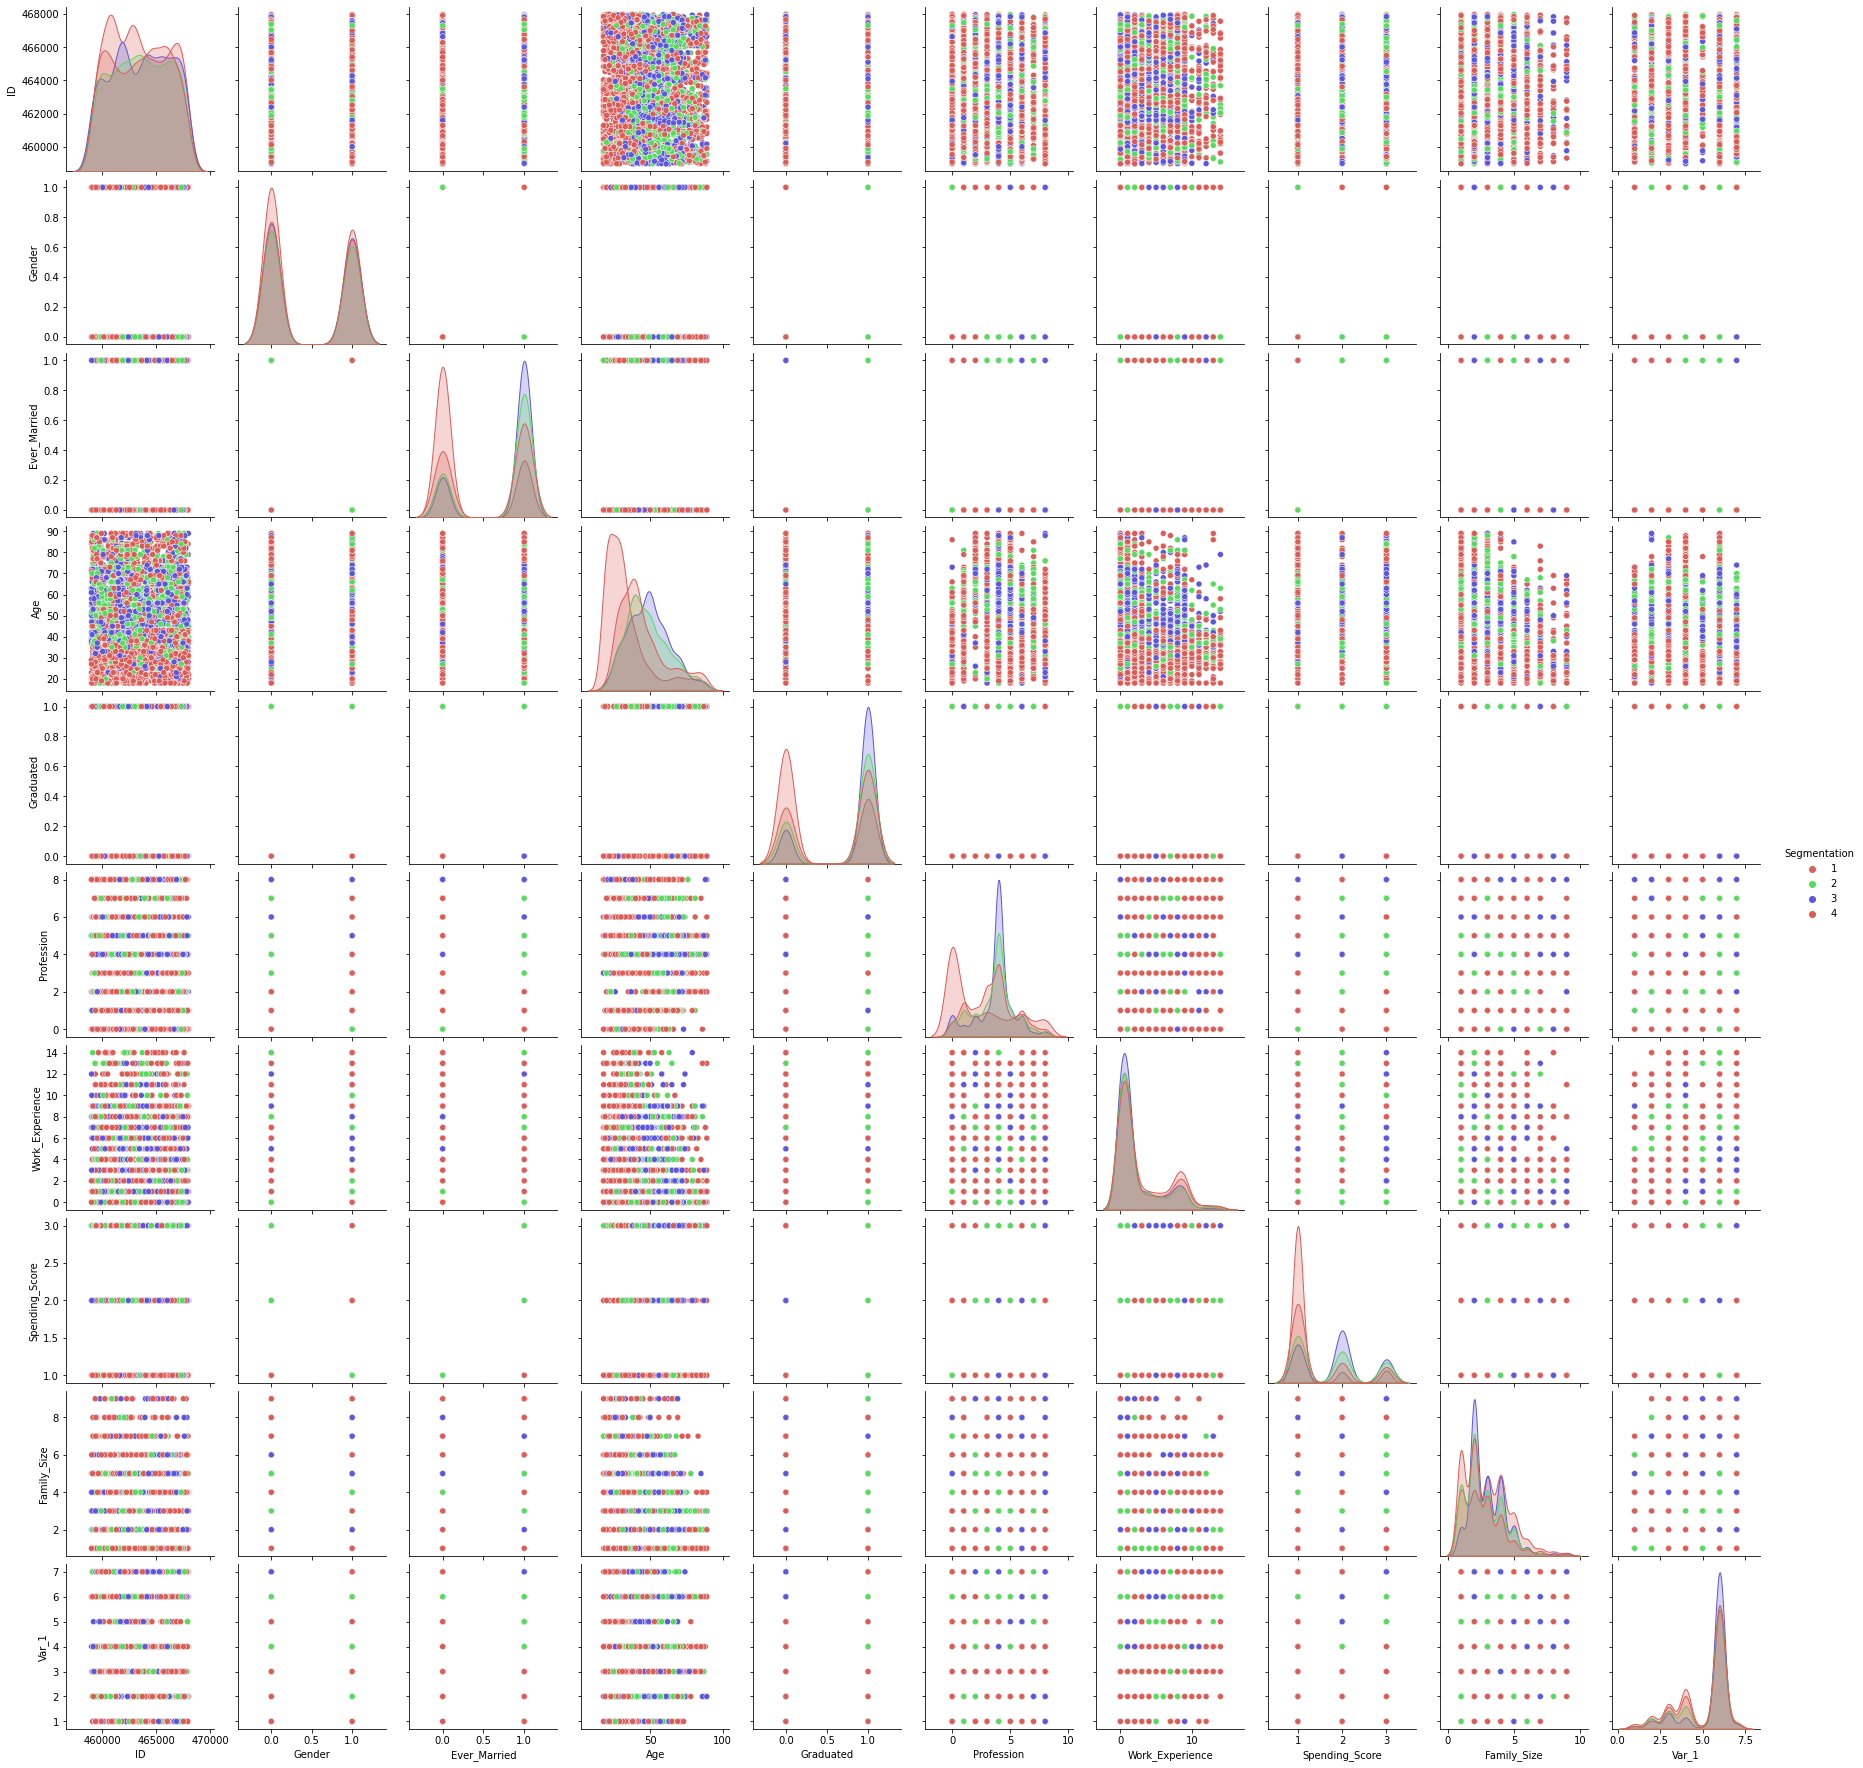

In [92]:

sns.pairplot(train, hue='Segmentation', palette=("hls"))

## EDA Conclussions 

1. Segmentation:
    * 1.1 I was not able to figure out what are the filters needed to be part of every segment. Below a table with the average for the numerical variables and the mode for the categorical variables:
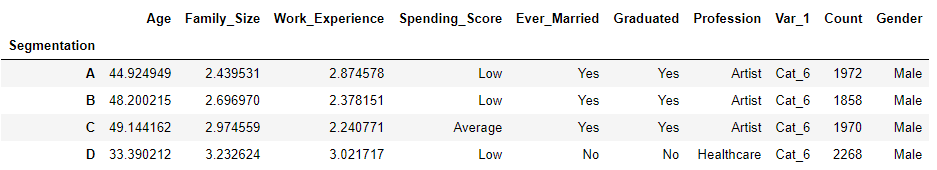
    * 1.2 The group D is having a lower Age Average  and the Mode for the proffesion is Healthcare. 
    * 1.3 The group C is haaving an Spending Score Higher, Proffesion is having a higher volume of Artists comparing with other segments. 
 
2. Proffesion: 
    * Artist 37%
    * Healthcare 16% 
    * Entertaiment 11%
 
3. Gender:
    * Male 54 %
    * Female 45%
4. Graduated:
    * Yes 62%
    * No 37%

5. Family Size: 
    * 2 - 30%
    * 3 - 19%
    * 1 - 18%
    * 4 - 17%
  
6. Correlation: 
   * 6.1 Correlation related to the Segmentation
       * Even Married
       * Age
       * Graduated
       * Family Size
  * 6.2 Correlation related Spending Code
       * Ever Married 
       * Age

## Data Cleaning - Fill/Impute Missing Values Continuous - Mean/Median/Any Specific Value & Categorical - Others/ForwardFill/BackFill.
